In [1]:
import sys
sys.path.append('./pyuid3')

In [2]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from pyuid3.entropy_evaluator import *
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [4]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))

Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<AxesSubplot:xlabel='x1', ylabel='x2'>

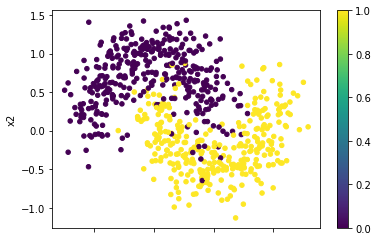

In [6]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [7]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [8]:
from sklearn.linear_model import LogisticRegression
xclf = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [9]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9333333333333333
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       153
           1       0.94      0.94      0.94       177

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



<AxesSubplot:xlabel='x1', ylabel='x2'>

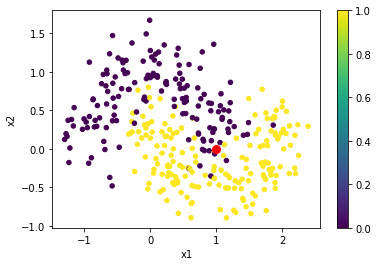

In [10]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [11]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['x1','x2']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Decision Boundaries

X does not have valid feature names, but SVC was fitted with feature names


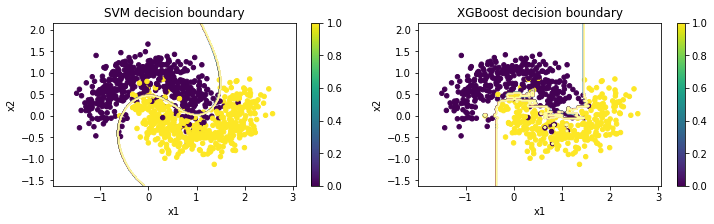

In [12]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

X does not have valid feature names, but SVC was fitted with feature names


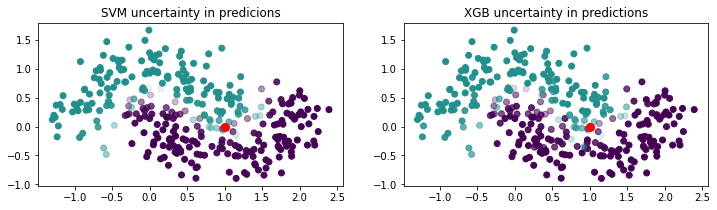

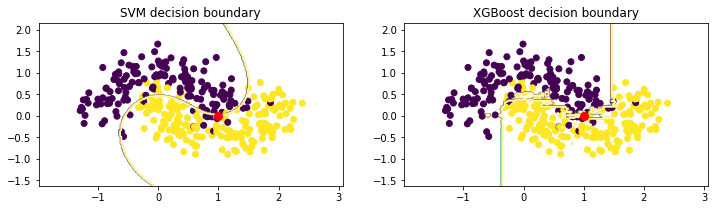

In [13]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## LUX explanations

In [14]:
from lux.lux import LUX

In [15]:
point = [0,1]
clf = xclf

lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(X_train, y_train,np.array([point]),X_importances = None, exclude_neighbourhood=False, use_parity=True, inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=True, representative='centroid')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In [16]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE,ADASYN,SVMSMOTE

In [17]:
def outliers(data,multiplier=1.5):
    # finding the 1st quartile
    q1 = np.quantile(data, 0.25)

    # finding the 3rd quartile
    q3 = np.quantile(data, 0.75)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(multiplier*iqr)
    lower_bound = q1-(multiplier*iqr)
    return (iqr, upper_bound, lower_bound)

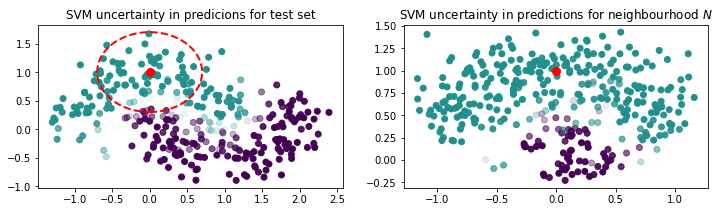

In [18]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood.png')

In [19]:
import warnings
warnings.filterwarnings('ignore')
#for i in np.arange(10):
for c in np.unique(y_train):
    X_train_input_c  = X_train_sample.loc[clf.predict(X_train_sample) ==c]
    prediction_certainty = np.max(clf.predict_proba(X_train_input_c), axis=1)
    #_,_,confidence_threshold = outliers(prediction_certainty,multiplier=1.5)
    confidence_threshold = np.mean(prediction_certainty)-np.std(prediction_certainty)
    X_train_input = X_train_input_c[prediction_certainty<confidence_threshold]
    predictions = clf.predict(X_train_sample)
    unique, counts = np.unique(predictions, return_counts=True)
    try:
        sm = BorderlineSMOTE(random_state=42)#,k_neighbors=min(5,min(counts)))#,m_neighbors=min(min(counts),10))
        X_train_input = pd.concat([X_train_input, X_train_sample[clf.predict(X_train_sample) !=c]])
        X_input_c,_ = sm.fit_resample(X_train_input, clf.predict(X_train_input))
        concatdf = pd.concat((X_input_c, X_train_sample))
        X_train_sample =concatdf.loc[~concatdf.duplicated()]
    except:
        print('Error')
        pass


## Neighbourhood plotting

In [20]:
sm = SMOTE(random_state=42)
X_train_sample,_ = sm.fit_resample(X_train_sample, clf.predict(X_train_sample))

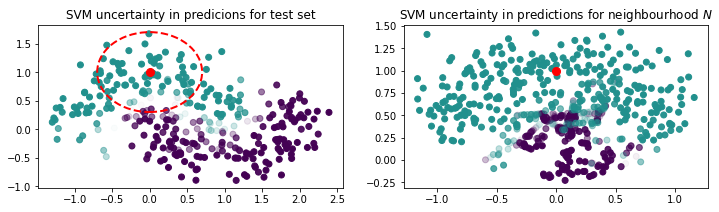

In [21]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood2.png')

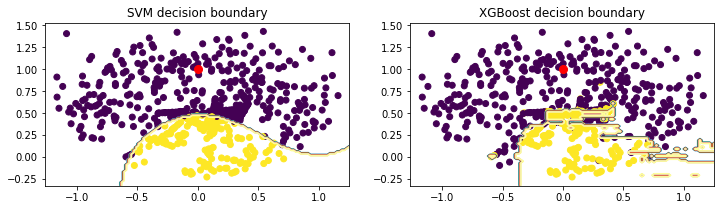

In [22]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_train_sample.values[:, 0].min() - 0.1, X_train_sample.values[:, 0].max() + 0.1
y_min, y_max = X_train_sample.values[:, 1].min() - 0.1, X_train_sample.values[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_train_sample['x1'], X_train_sample['x2'], c=svc.predict(X_train_sample), cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_train_sample['x1'], X_train_sample['x2'], c=clf.predict(X_train_sample), cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
plt.show()

In [23]:
X_train_sample.shape

(856, 2)

In [24]:
clfgb = xgb.XGBClassifier(eval_metric='error')
clfgb.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
explainer = shap.Explainer(clfgb, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [26]:
shap_values[0]
explainer.expected_value

0.5431818945561969

In [27]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [28]:
uarff=LUX.generate_uarff(X_train_sample,clf.predict_proba(X_train_sample), X_importances=None,class_names=[0,1])
data = Data.parse_uarff_from_string(uarff)

In [29]:
datadf = data.to_dataframe()
shap_dict={}
expected_dict={}
expected_values = explainer.expected_value
for i,v in enumerate(shap_values):
    shap_dict[str(i)] = pd.DataFrame(v, columns = datadf.columns[:-1])
    expected_dict[str(i)] = expected_values[i]

data = data.set_importances(pd.concat(shap_dict,axis=1), expected_values = expected_dict)

In [30]:
data.instances[-1].get_reading_for_attribute('x2').get_most_probable().get_importances()

{'0': -0.030499999318271874, '1': 0.030499999318271874}

In [31]:
def get_maximum_label(shapdict):
            return max(shapdict, key=shapdict.get)
        
labels = [get_maximum_label(i.get_reading_for_attribute('x2').get_most_probable().get_importances()) for i in data.instances]

In [32]:
true_labels = [i.get_reading_for_attribute(data.get_class_attribute().get_name()).get_most_probable().get_name() for i in data.instances]

In [33]:
len(true_labels)

856

In [34]:
len(labels)

856

In [35]:
sum(np.array(labels)==np.array(true_labels))/len(labels)

0.8855140186915887

In [36]:
tlabels = clf.predict(datadf.iloc[:,:-1])

In [37]:
ilabels = [int(i) for i in labels]

In [38]:
(tlabels==ilabels).sum()/len(labels)

0.8855140186915887

In [39]:
idx_error_x1 = datadf.iloc[np.where(tlabels!=ilabels)].index 
datadf.loc[:,'x2_shap_error'] =datadf['class']
datadf.loc[idx_error_x1,'x2_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

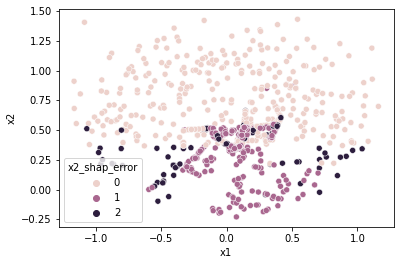

In [40]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x2_shap_error')

In [41]:
labelsx1 = [get_maximum_label(i.get_reading_for_attribute('x1').get_most_probable().get_importances()) for i in data.instances]

In [42]:
ilabelsx1 = [int(i) for i in labelsx1]
(tlabels==ilabelsx1).sum()/len(labels)

0.844626168224299

In [43]:
idx_error_x1 = datadf.iloc[np.where(tlabels!=ilabelsx1)].index 
datadf.loc[:,'x1_shap_error'] =datadf['class']
datadf.loc[:,'x1_shap'] =ilabelsx1
datadf.loc[idx_error_x1,'x1_shap_error'] = 2
datadf = datadf.fillna(0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

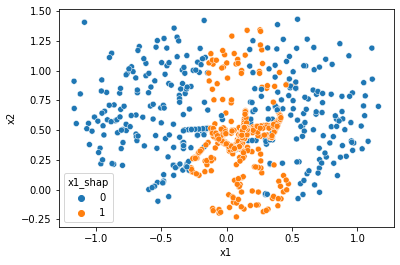

In [44]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap')

<AxesSubplot:xlabel='x1', ylabel='x2'>

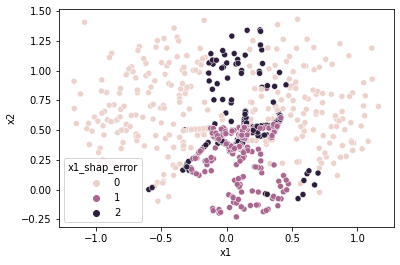

In [45]:
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1_shap_error')

<AxesSubplot:xlabel='x1', ylabel='x2'>

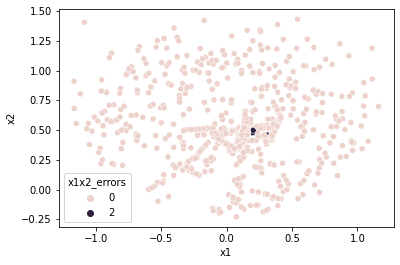

In [46]:
datadf['x1x2_errors']=0
datadf.loc[(datadf['x1_shap_error']==2) & (datadf['x2_shap_error']==2),'x1x2_errors'] =2
sns.scatterplot(data=datadf,x='x1',y='x2',hue='x1x2_errors')

In [47]:
stats = data.calculate_statistics(data.get_attribute_of_name('x1'))

In [48]:
stats.get_avg_abs_importance()

0.2966447363601271

In [49]:
stats = data.calculate_statistics(data.get_attribute_of_name('x2'))

In [50]:
stats.get_avg_abs_importance()

0.3822699680911141

In [51]:
import sys
sys.path.append('./EXPLAN')
sys.path.append('./EXPLAN/LORE')
from LORE import lore
from LORE.neighbor_generator import *

In [52]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets
import warnings
warnings.filterwarnings("ignore")


# Reading and preparing data set
path_data = './EXPLAN/datasets/'
dataset_name = 'compas-scores-two-years.csv'
dataset = prepare_compass_dataset(dataset_name, path_data)

# Splitting the data set into train and test sets
X, y = dataset['X'], dataset['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 10
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 3000
tau = 250

# # Explaining instance x using EXPLAN
# exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
#                                            blackbox,
#                                            dataset,
#                                            N_samples=N_samples,
#                                            tau=tau)

# # Reporting the results
# dfX2E = build_df2explain(blackbox, X_test, dataset).to_dict('records')
# dfx = dfX2E[index]
# print('x = %s' % dfx)

# print('e = %s' % exp_EXPLAN[1])
# print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
# print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])




In [53]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets
import warnings
warnings.filterwarnings("ignore")
features = ['x1','x2']
# df = datadf[features+['class']]
# df['class'] = df['class'].astype(int)


X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))
df = pd.DataFrame(X, columns=['x1','x2'])
df['class'] = y

In [54]:
from sklearn.preprocessing import LabelEncoder
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder=[]):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset
    

In [55]:
import os
import pickle
from sklearn.preprocessing import StandardScaler
directory = './data/numerical_only/balanced'


for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    break
(data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
features = [f'f_{i}' for i in range(0,data.shape[1])]
target = 'class'
df = pd.DataFrame(data,columns=features,dtype=float)
sc = StandardScaler()
df.loc[:]=sc.fit_transform(df)#normalize(df, axis=0)#sc.fit_transform(df)
df[target] = y

In [56]:
#myds = prepare_ds(df,discrete=[False,False])
myds = prepare_ds(df,discrete=[False]*len(features))
X, y = myds['X'], myds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 3
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 500
tau = 250

# Explaining instance x using EXPLAN
exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                           blackbox,
                                           myds,
                                           N_samples=N_samples,
                                           tau=tau)

# Reporting the results
dfX2E = build_df2explain(blackbox, X_test, myds).to_dict('records')
dfx = dfX2E[index]
print('x = %s' % dfx)
print('e = %s' % exp_EXPLAN[1])
print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])
#print(f'{class_name}, {columns}, {features_type}, {discrete}, {continuous}')

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
X_explain = np.concatenate(([instance2explain], myds['X']))
anchor_explainer = fit_anchor(myds, X_train, X_test, y_train, y_test, X_explain)
ee = anchor_explainer.explain_instance(X_explain[3].reshape(1, -1),
                                                            blackbox.predict, threshold=0.95)

In [ ]:
ee.names()

In [ ]:
ee.exp_map['prediction']

In [ ]:
ee.show_in_notebook()

In [ ]:
import explan
from utils import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.datasets

def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder=[]):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset

X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)
XX=np.concatenate((X,X,X,X),axis=1)
features = [f'f_{i}' for i in range(0,XX.shape[1])]
df = pd.DataFrame(XX, columns=features)
df['class'] = y

myds = prepare_ds(df,discrete=[False]*len(features))
X, y = myds['X'], myds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Creating black-box model
blackbox = GradientBoostingClassifier(random_state=42)
blackbox.fit(X_train, y_train)

# Selecting instance to explain
index = 0
instance2explain = X_test[index]

# EXPLAN hyper-parameters
N_samples = 3000
tau = 500

# Explaining instance x using EXPLAN
exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                           blackbox,
                                           myds,
                                           N_samples=N_samples,
                                           tau=tau)

# Reporting the results
dfX2E = build_df2explain(blackbox, X_test, myds).to_dict('records')
dfx = dfX2E[index]
print('x = %s' % dfx)
print('e = %s' % exp_EXPLAN[1])
print('Black-box prediction = %s' % info_EXPLAN['y_x_bb'])
print('C4.5 Tree prediction = %s' % info_EXPLAN['y_x_dt'])




exp_LORE, info_LORE = lore.explain(1, myds['X'],
                                   myds, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path=path_data,
                                   sep=';', log=True)


In [ ]:
exp_LORE

In [ ]:
list(exp_EXPLAN[1].keys())

In [ ]:
exp_EXPLAN

In [ ]:
#pyyadt.predict(info_EXPLAN['C'], df.to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])

In [ ]:
sum(info_EXPLAN['y_X_bb']==info_EXPLAN['y_X_dt'])/len(info_EXPLAN['y_X_dt'])

In [ ]:
#build_df2explain(blackbox, X_test, myds)

In [ ]:



columns = myds['columns']
features_type = myds['features_type']
discrete = myds['discrete']
label_encoder = myds['label_encoder']

y = blackbox.predict(X_test)
yX = np.concatenate((X_test,y.reshape(-1, 1)), axis=1)
data = list()
for i, col in enumerate(columns):
    data_col = yX[:, i]
    data_col = data_col.astype(int) if col in discrete else data_col
    data_col = data_col.astype(int) if features_type[col] == 'integer' else data_col
    data.append(data_col)
# data = map(list, map(None, *data))
data = [[d[i] for d in data] for i in range(0, len(data[0]))]
dfZ = pd.DataFrame(data=data, columns=columns)
#dfZ = label_decode(dfZ, discrete, label_encoder)

In [ ]:
for i, col in enumerate(columns):
    print( features_type[col])

In [ ]:
import os
import pickle

In [ ]:
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
rs=42
init_fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=5
show=True
ismpl=True
synthetic = False
density_sampling=True
radius_sampling=False#True
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
n_jobs=-1

for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    features = [f'f_{i}' for i in range(0,data.shape[1])]
    if directory =='./data/numerical_only/balanced':
        categorical_indicator=[False]*len(features)
    continuous_indicator = np.logical_not(categorical_indicator)
    target = 'class'
    df = pd.DataFrame(data,columns=features,dtype=float)
    sc = StandardScaler()
    df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
    df[target] = y
    
        
        
    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if len(df) >6000:
        fraction = 1000.0/len(df)
    else:
        fraction = init_fraction
        
    
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs, shuffle=False)
    clf  = MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    break
    

In [ ]:
explain_instance = test[features].values[0,:]

In [ ]:
explain_instance=np.array(explain_instance).reshape(1,-1)
#explain_instance = test[features].sample(1).values#.astype('f8')    

instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')



n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
nn.fit(test[features])
dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
print(f'Neighbourhood size: {len(ids_c.ravel())}')
print(f'Average distace of neighbourhood: {np.mean(dst)}.')
dfneigh= test.iloc[ids_c.ravel()]


lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = 2, grow_confidence_threshold = 0)
X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance],
                                          X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                          use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                         representative=representative,density_sampling=density_sampling)

In [ ]:
%%time
print('Lux ww proba')
start_time = time.time()
#explain xgboost without proba, 
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
#This is commented out for the computational efficiency of the benchmark
# lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
#        radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
#       uncertain_entropy_evaluator=uncertain_entropy_evaluator)

## To make it faster, not repeat neighbourhood selection step every time:
y_train_sample = lux.predict_proba(X_train_sample)
#limit features here
uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
udata = Data.parse_uarff_from_string(uarff)
print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
lux.uid3.PARALLEL_ENTRY_FACTOR = 100
# if lux.classifier is not None:
#     lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
# else:
lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=1)

#time without val_cache: 1min 33sek
#time with val_chace: 48sek
#time with get funciton of dict: 47 sek
#time without copying instances when filtering the data: 26sek


In [ ]:
print('Lux ww proba')
start_time = time.time()
#explain xgboost without proba, 
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
#This is commented out for the computational efficiency of the benchmark
# lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
#        radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
#       uncertain_entropy_evaluator=uncertain_entropy_evaluator)

## To make it faster, not repeat neighbourhood selection step every time:
y_train_sample = lux.predict_proba(X_train_sample)
#limit features here
uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
udata = Data.parse_uarff_from_string(uarff)
print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
lux.uid3.PARALLEL_ENTRY_FACTOR = 100
# if lux.classifier is not None:
#     lux.tree = lux.uid3.fitshap(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
# else:
%prun lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=1)

In [ ]:
d={}
d['12']=4
d['34']=3

In [ ]:
for v in d.items():
    print(v[0])


In [ ]:
# 5 sek get instance

In [ ]:
15717   25.480    0.002   45.590    0.003 att_stats.py:25(calculate_statistics)
 7799   19.618    0.003   41.023    0.005 data.py:56(filter_numeric_attribute_value)
8855310    8.594    0.000    8.594    0.000 {method 'keys' of 'dict' objects}
8855310    5.515    0.000   14.270    0.000 instance.py:22(get_reading_for_attribute)
8774922    4.436    0.000    4.436    0.000 {method 'copy' of 'dict' objects}
22063207    3.290    0.000    3.290    0.000 value.py:19(get_name)

In [ ]:
15899   24.502    0.002   43.996    0.003 att_stats.py:25(calculate_statistics)
     7890   20.306    0.003   43.185    0.005 data.py:56(filter_numeric_attribute_value)
  9212500    9.519    0.000    9.519    0.000 {method 'copy' of 'dict' objects}
  4584272    5.791    0.000    5.791    0.000 instance.py:30(set_readings)
  9293086    3.787    0.000    6.059    0.000 instance.py:22(get_reading_for_attribute)
 18508924    3.322    0.000    3.406    0.000 {method 'get' of 'dict' objects}
  4644337    2.650    0.000    5.468    0.000 {built-in method builtins.sum}

In [58]:
import gower

In [59]:
Xg=gower.gower_matrix(X)

In [60]:
nn=NearestNeighbors(n_neighbors=1,metric='precomputed')

In [61]:
nn.fit(Xg)

NearestNeighbors(metric='precomputed', n_neighbors=1)

In [62]:
ionstance_to_explain = X[0:1,:]

In [63]:
ionstance_to_explain

array([[-0.11742365,  0.75120054, -0.41960177, -0.49447725, -0.60170682,
         0.86755262, -0.34657387,  0.88327091,  0.36255575, -0.67503049,
         0.33312778, -0.40612234,  0.30964042,  0.58921693,  0.21791891,
        -0.40504142]])

In [64]:
gower.gower_matrix(ionstance_to_explain,X).shape

(1, 13488)

In [65]:
gower.gower_matrix(X,ionstance_to_explain).shape

(13488, 1)

In [ ]:
ii=gower.gower_topn(ionstance_to_explain,X)['index']

In [ ]:
X[ii.ravel()[0]]

In [ ]:
nn.n_neighbors

In [57]:
sum([True, False, False])

1